In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

print(f"\nDataset loaded successfully")
print(f"Total number of images: {lfw_dataset.images.shape[0]}")
print(f"Image dimensions: {lfw_dataset.images.shape[1]} x {lfw_dataset.images.shape[2]}")
print(f"Number of features (pixels): {lfw_dataset.data.shape[1]}")
print(f"Number of classes (people): {len(lfw_dataset.target_names)}")
print(f"\nPeople in dataset: {lfw_dataset.target_names}")


Dataset loaded successfully
Total number of images: 1288
Image dimensions: 50 x 37
Number of features (pixels): 1850
Number of classes (people): 7

People in dataset: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [7]:
X = lfw_dataset.data          # image pixels
y = lfw_dataset.target        # labels
target_names = lfw_dataset.target_names
n_features = X.shape[1]


Class Distribution:
              Person  Count
0       Ariel Sharon     77
1       Colin Powell    236
2    Donald Rumsfeld    121
3      George W Bush    530
4  Gerhard Schroeder    109
5        Hugo Chavez     71
6         Tony Blair    144


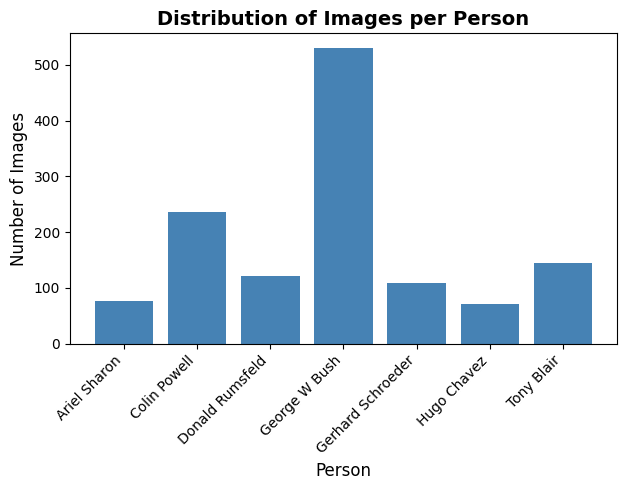

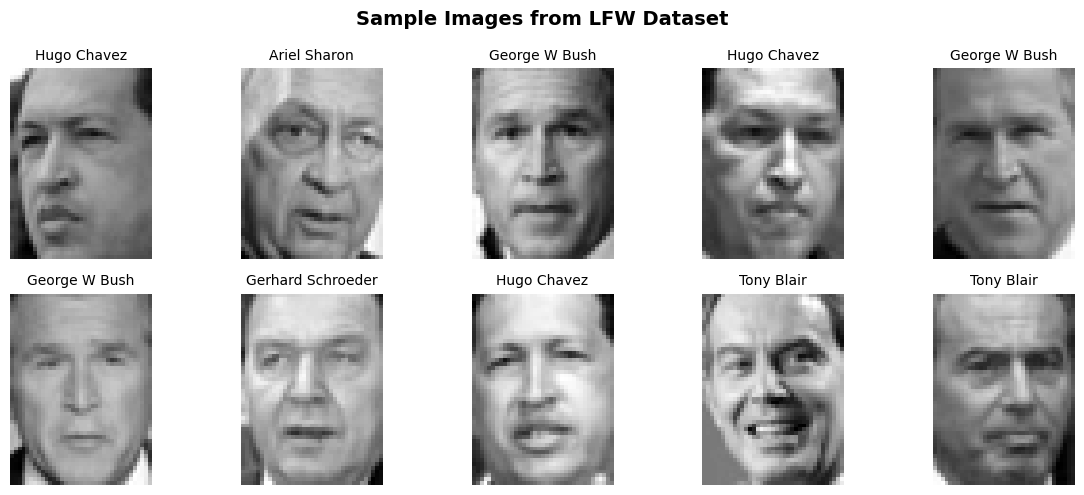

In [8]:

unique, counts = np.unique(y, return_counts=True)
class_distribution = pd.DataFrame({
    'Person': [target_names[i] for i in unique],
    'Count': counts
})

print(f"\nClass Distribution:")
print(class_distribution)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(class_distribution['Person'], class_distribution['Count'], color='steelblue')
plt.xlabel('Person', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images per Person', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


fig_samples, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    if i < 10:
        ax.imshow(lfw_dataset.images[i * 50], cmap='gray')
        ax.set_title(target_names[y[i * 50]], fontsize=10)
    ax.axis('off')
plt.suptitle('Sample Images from LFW Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")
print(f"  Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.2f}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

  Training samples: 966
  Testing samples: 322
  Train/Test ratio: 3.00


Mean face shape: (1850,)
Mean face values - Min: -0.0000, Max: 0.0000


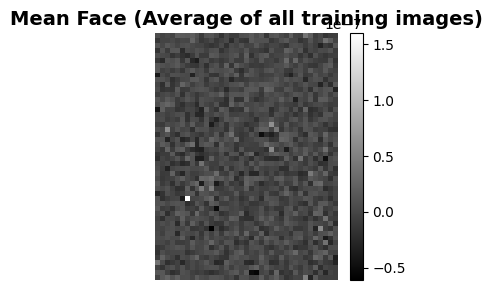

Centered data shape: (966, 1850)
Centered data mean: 0.0000000006 (should be ~0)
Number of components: 150
Reduced data shape: (966, 150)
Original features: 1850

Top 10 Eigenvalues:
  λ1 = 469.4204
  λ2 = 272.6215
  λ3 = 126.5399
  λ4 = 91.0986
  λ5 = 58.2434
  λ6 = 51.6046
  λ7 = 38.6027
  λ8 = 31.9790
  λ9 = 30.1519
  λ10 = 27.6530


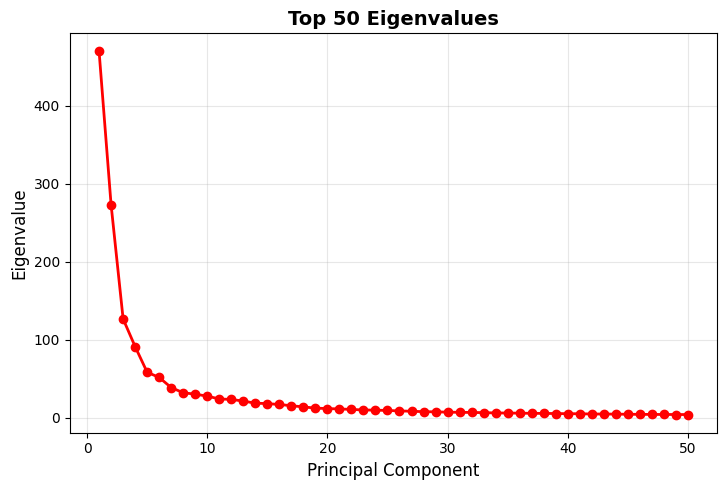

In [10]:
mean_face = np.mean(X_train_scaled, axis=0)
print(f"Mean face shape: {mean_face.shape}")
print(f"Mean face values - Min: {mean_face.min():.4f}, Max: {mean_face.max():.4f}")

h, w = lfw_dataset.images.shape[1], lfw_dataset.images.shape[2]
plt.figure(figsize=(3, 3))
plt.imshow(mean_face.reshape(h, w), cmap='gray')
plt.title('Mean Face (Average of all training images)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

X_centered = X_train_scaled - mean_face
print(f"Centered data shape: {X_centered.shape}")
print(f"Centered data mean: {X_centered.mean():.10f} (should be ~0)")

n_components = min(150, X_train_scaled.shape[0] - 1)
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Number of components: {pca.n_components_}")
print(f"Reduced data shape: {X_train_pca.shape}")
print(f"Original features: {n_features}")

eigenvalues = pca.explained_variance_
print(f"\nTop 10 Eigenvalues:")
for i in range(min(10, len(eigenvalues))):
    print(f"  λ{i+1} = {eigenvalues[i]:.4f}")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(range(1, min(50, len(eigenvalues))+1), eigenvalues[:50], 'ro-', linewidth=2, markersize=6)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.title('Top 50 Eigenvalues', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Variance explained by first 10 components:
  PC1: 25.35%
  PC2: 14.72%
  PC3: 6.83%
  PC4: 4.92%
  PC5: 3.15%
  PC6: 2.79%
  PC7: 2.08%
  PC8: 1.73%
  PC9: 1.63%
  PC10: 1.49%

Cumulative variance explained:
  First 10 components: 64.69%
  First 50 components: 84.61%
  First 100 components: 91.38%
  First 150 components: 94.48%


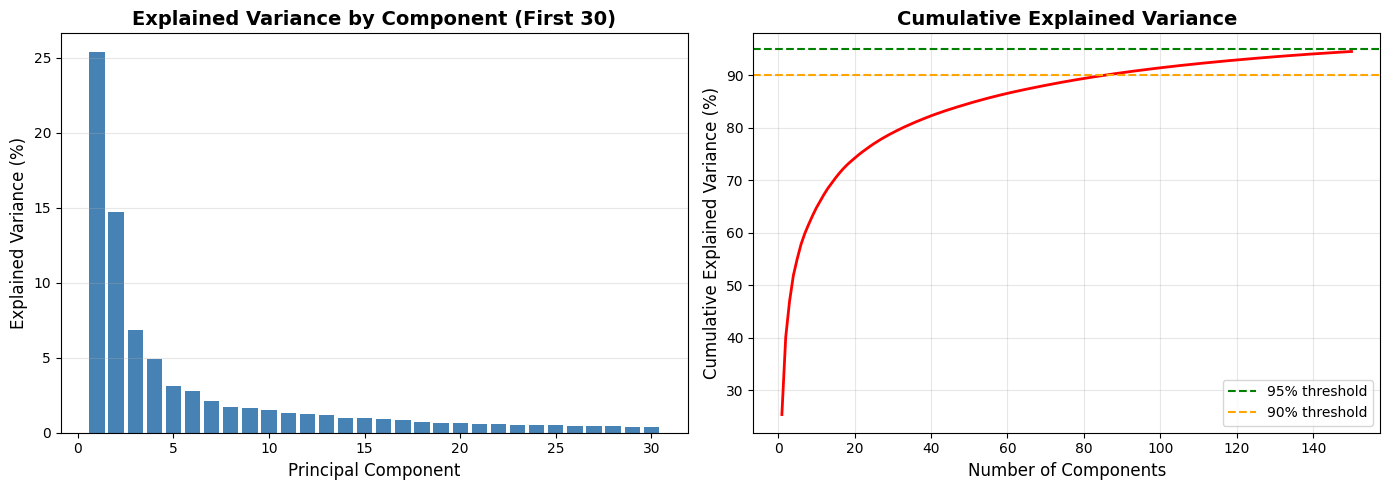

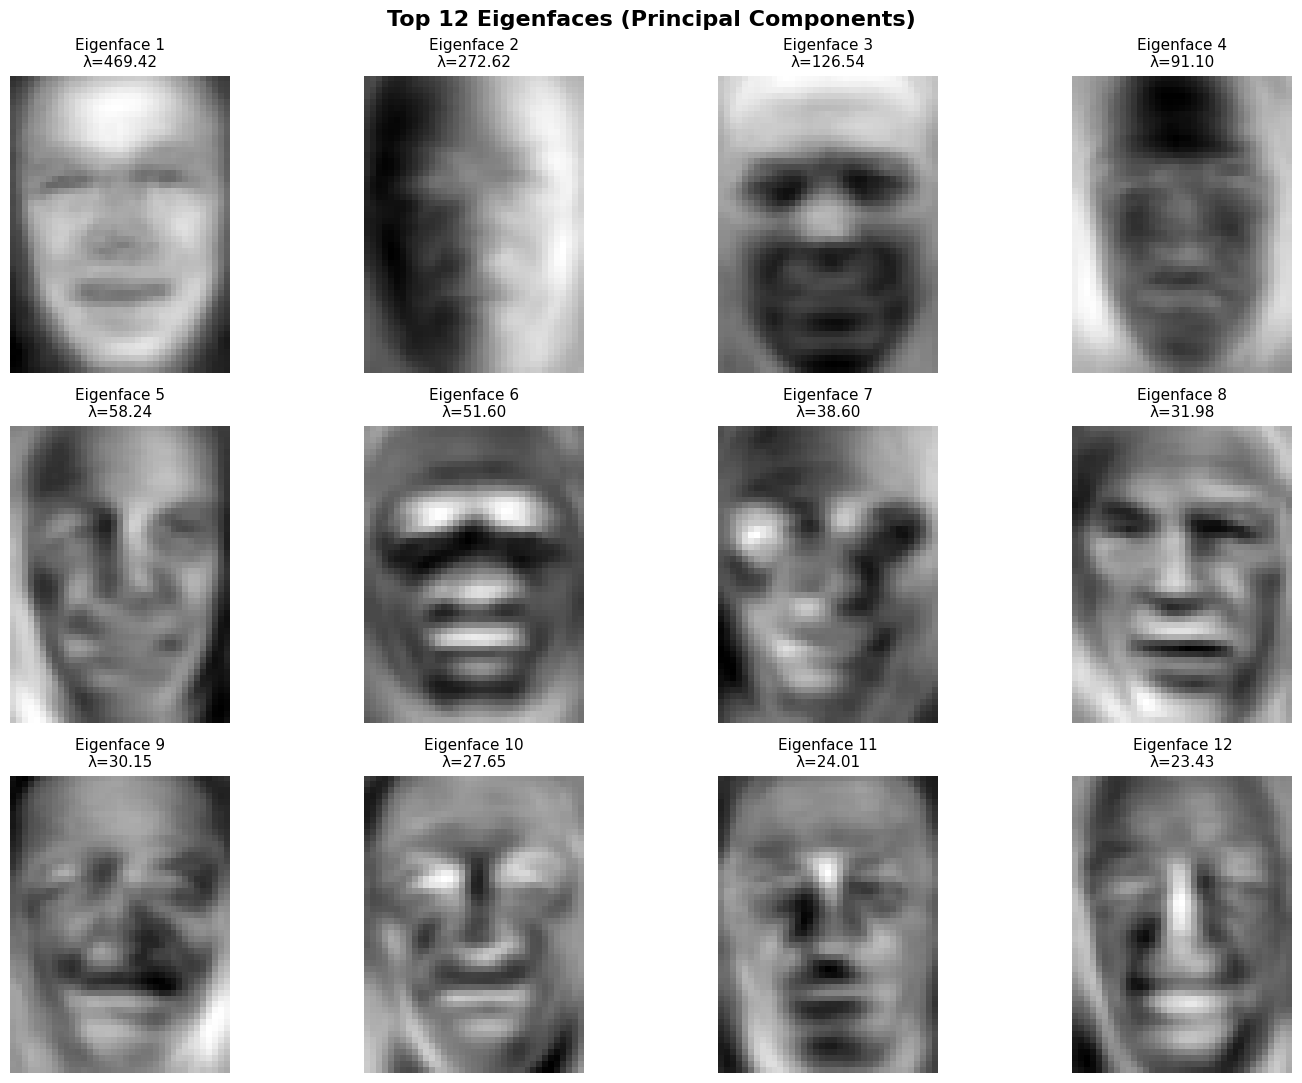

Test data transformed shape: (322, 150)


In [11]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\nVariance explained by first 10 components:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"  PC{i+1}: {explained_variance_ratio[i]*100:.2f}%")

print(f"\nCumulative variance explained:")
for n in [10, 50, 100, n_components]:
    if n <= len(cumulative_variance):
        print(f"  First {n} components: {cumulative_variance[n-1]*100:.2f}%")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
n_bars = min(30, len(explained_variance_ratio))
plt.bar(range(1, n_bars+1),
        explained_variance_ratio[:n_bars]*100, color='steelblue')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance (%)', fontsize=12)
plt.title(f'Explained Variance by Component (First {n_bars})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance*100,
         'r-', linewidth=2)
plt.axhline(y=95, color='g', linestyle='--', label='95% threshold')
plt.axhline(y=90, color='orange', linestyle='--', label='90% threshold')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=12)
plt.title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

eigenvectors = pca.components_

n_eigenfaces = min(12, eigenvectors.shape[0])
fig, axes = plt.subplots(3, 4, figsize=(15, 11))
for i, ax in enumerate(axes.flat):
    if i < n_eigenfaces:
        eigenface = eigenvectors[i].reshape(h, w)
        ax.imshow(eigenface, cmap='gray')
        ax.set_title(f'Eigenface {i+1}\nλ={eigenvalues[i]:.2f}', fontsize=11)
    ax.axis('off')
plt.suptitle('Top 12 Eigenfaces (Principal Components)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

X_test_pca = pca.transform(X_test_scaled)
print(f"Test data transformed shape: {X_test_pca.shape}")

In [13]:
svm_initial = SVC(kernel='rbf', random_state=42)
svm_initial.fit(X_train_pca, y_train)

y_train_pred_initial = svm_initial.predict(X_train_pca)
y_test_pred_initial = svm_initial.predict(X_test_pca)

train_acc_initial = accuracy_score(y_train, y_train_pred_initial)
test_acc_initial = accuracy_score(y_test, y_test_pred_initial)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

print(f"\nBest parameters found:")
print(f"   C: {grid_search.best_params_['C']}")
print(f"   Gamma: {grid_search.best_params_['gamma']}")
print(f"   Kernel: {grid_search.best_params_['kernel']}")
print(f"   Best CV Score: {grid_search.best_score_*100:.2f}%")

best_svm = grid_search.best_estimator_

y_train_pred = best_svm.predict(X_train_pca)
y_test_pred = best_svm.predict(X_test_pca)

print(f"\nNumber of Support Vectors: {best_svm.n_support_}")
print(f"Support vectors per class:")
for i, name in enumerate(target_names):
    print(f"  - {name}: {best_svm.n_support_[i]}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters found:
   C: 100
   Gamma: 0.0001
   Kernel: rbf
   Best CV Score: 83.23%

Number of Support Vectors: [ 52 130  64 223  76  47  85]
Support vectors per class:
  - Ariel Sharon: 52
  - Colin Powell: 130
  - Donald Rumsfeld: 64
  - George W Bush: 223
  - Gerhard Schroeder: 76
  - Hugo Chavez: 47
  - Tony Blair: 85


                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.68      0.68        19
     Colin Powell       0.81      0.93      0.87        59
  Donald Rumsfeld       0.75      0.60      0.67        30
    George W Bush       0.87      0.95      0.91       133
Gerhard Schroeder       0.95      0.74      0.83        27
      Hugo Chavez       0.93      0.78      0.85        18
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.85       322
        macro avg       0.85      0.78      0.81       322
     weighted avg       0.85      0.85      0.85       322



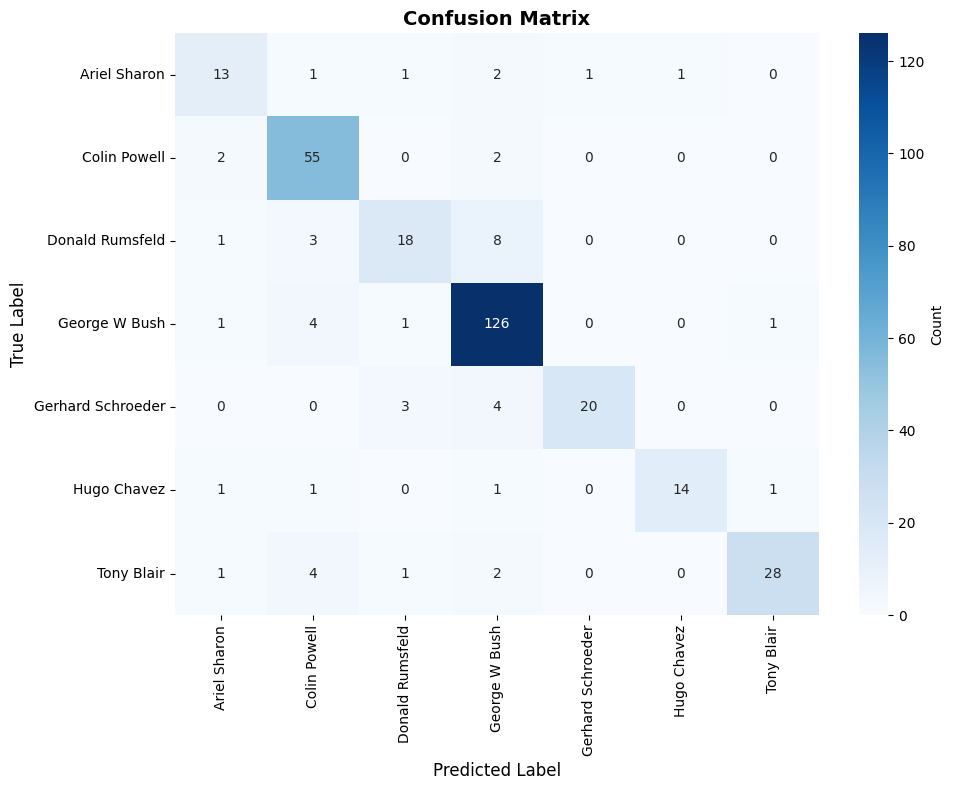

In [14]:
print(classification_report(y_test, y_test_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Making predictions on 12 random test images...



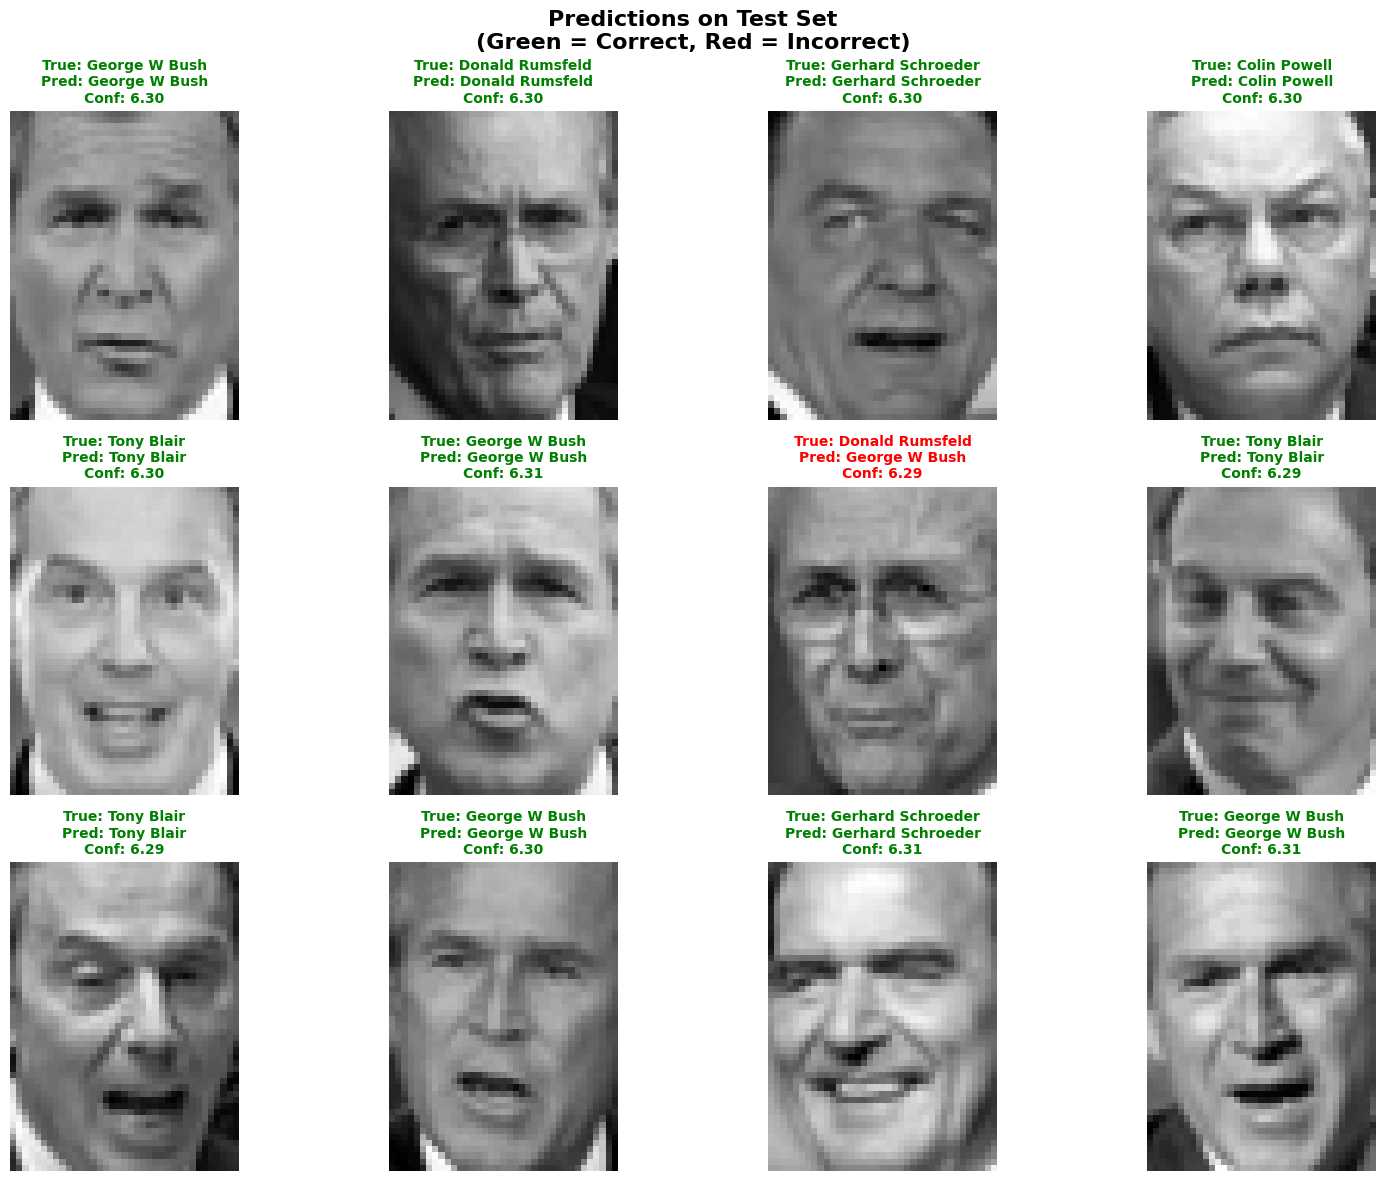

In [15]:
n_predictions = 12
random_indices = np.random.choice(len(X_test), n_predictions, replace=False)

print(f"\nMaking predictions on {n_predictions} random test images...\n")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx, ax in enumerate(axes.flat):
    if idx < n_predictions:
        test_idx = random_indices[idx]

        image = X_test[test_idx].reshape(h, w)
        true_label = target_names[y_test[test_idx]]
        pred_label = target_names[y_test_pred[test_idx]]

        decision = best_svm.decision_function([X_test_pca[test_idx]])
        confidence = np.max(decision)

        ax.imshow(image, cmap='gray')

        color = 'green' if true_label == pred_label else 'red'

        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                    color=color, fontsize=10, fontweight='bold')
        ax.axis('off')

plt.suptitle('Predictions on Test Set\n(Green = Correct, Red = Incorrect)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()